## Miscellaneous figures

This notebook contains the code to generate several miscellaneous figures:
* Scatter plots of forecast generated using local, site weather and weather from the San Juan Airport
* Airport vs. local weather

Results are stored in `output/misc_figures`

Start by importing necessary libraries and turning off warnings

In [ ]:
import os, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import nbinom as nbinom
sys.path.append( os.path.abspath(os.path.join('..')) )
import utils.utils as gen_utils

import warnings
warnings.filterwarnings('ignore')

# Opening config file
f = open('../fpaths_config.json')
paths = json.load(f)

raw_data_path = paths['raw_data']
smoothed_data_path = paths['smoothed_data']
misc_figures_path = paths['misc_figures_path']
scaling_rto_fil = paths["scaling_rto_fil"]
baseline_scaling_rto_fil = paths["baseline_scaling_rto_fil"]

## Plots of forecast generated from local site weather data and weather from San Juan airport

In [ ]:
sites = ['Arboleda', 'La_Margarita', 'Playa', 'Villodas']
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,8))
axs = axs.ravel()

for i in range(len(sites)):
    ax = axs[i]
    site = sites[i]
    #Raw trap data
    site_fil = '{}/{}_site_raw_weekly_predictions.csv'.format(raw_data_path,site)
    airport_fil = '{}/{}_airport_raw_weekly_predictions.csv'.format(raw_data_path,site)
    site_preds = gen_utils.load_csv(site_fil)    
    airport_preds = gen_utils.load_csv(airport_fil)

    site_preds.Datetime = pd.to_datetime(site_preds.Datetime)
    airport_preds.Datetime = pd.to_datetime(airport_preds.Datetime)

    ax.plot(site_preds.Datetime, site_preds['Neural Network'], label='Abundance curve\n(local weather)', color='tab:blue')
    ax.plot(airport_preds.Datetime, airport_preds['Neural Network'], label='Abundance curve\n(airport weather)', color='tab:orange')
    
    ax.set_title(site.replace('_', ' '))
    if i==0:
        legend = ax.legend(loc='lower left', ncol=2, columnspacing=0.7, handlelength=1)
    if (i%2)==0:
        ax.set_ylabel('Weekly Abundance')
plt.subplots_adjust(wspace=0.1, hspace=0.15)
fig.savefig('{}/site_vs_airport_preds.png'.format(misc_figures_path), dpi=300, bbox_inches='tight')



## Airport vs. local weather

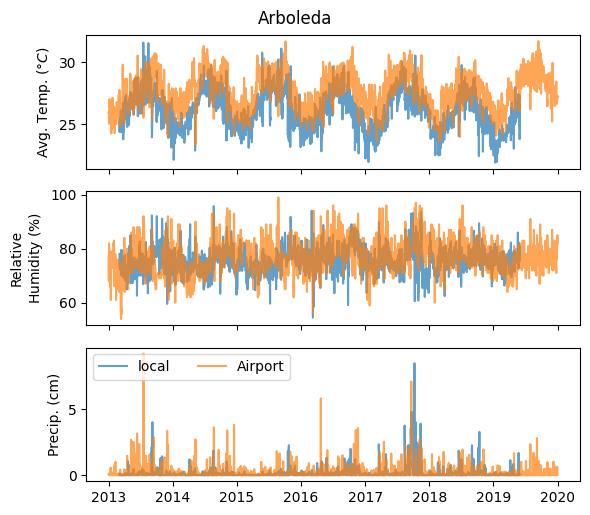

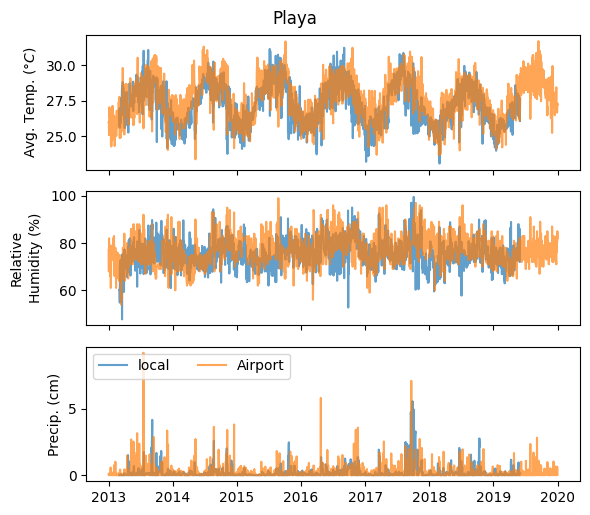

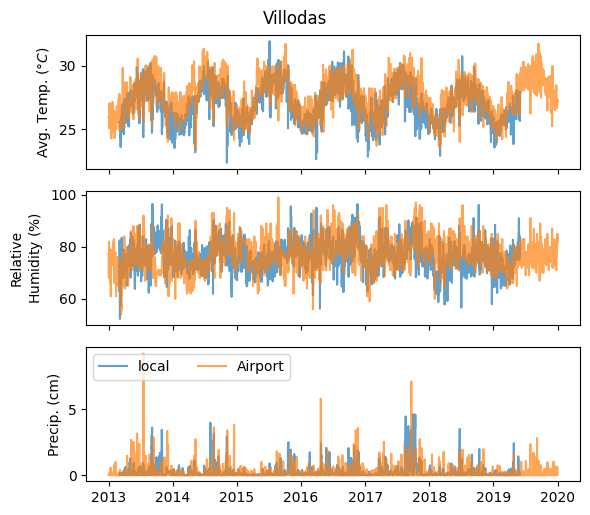

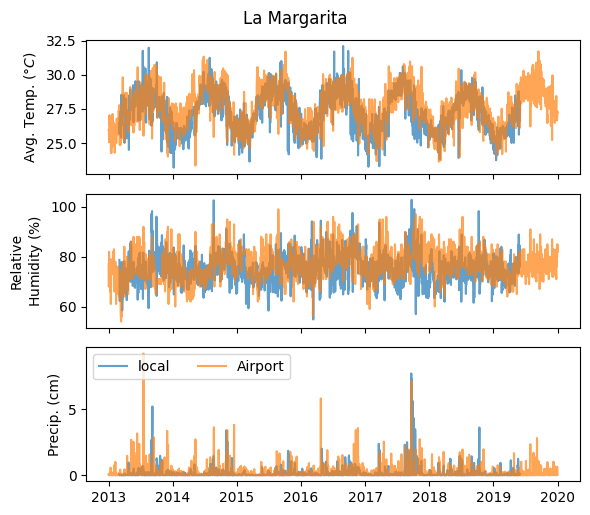

In [24]:
sites = ['Arboleda', 'Playa', 'Villodas', 'La_Margarita']

airport_fil = '../data/Weather/san_juan_airport.csv'
airport = pd.read_csv(airport_fil)
airport['Datetime'] = pd.to_datetime(airport.Datetime)

for site in sites:
    local_fil = '../data/Weather/{}_daily.pd'.format(site)
    local = pd.read_pickle(local_fil)
    local['Datetime'] = pd.to_datetime(local.Datetime)
    
    fig, axs = plt.subplots(3,1, sharex=True, sharey=False, figsize=(6,5))
    axs = axs.ravel()

    col_plts = ['Avg_Temp', 'Humidity', 'Precip']
    names = ['Avg. Temp. ($\degree C$)', 'Relative\nHumidity ($\%$)', 'Precip. (cm)']

    for col,name,ax in zip(col_plts, names, axs):
        ax.plot(local.Datetime, local[col], label='local', alpha=0.7, color='tab:blue')
        ax.plot(airport.Datetime, airport[col], label='Airport', alpha=0.7, color='tab:orange')
        ax.set_ylabel(name)
    ax.legend(loc='upper left', ncol=2)
    fig.tight_layout()
    fig.suptitle(site.replace('_', ' '), y=1.02)
    fig.savefig('{}/{}_weather_comparison.png'.format(misc_figures_path,site), dpi=300, bbox_inches='tight')


## Show how $p$ and $n$ change over time for each location

In [ ]:
sites = ['Arboleda', 'Playa', 'La_Margarita', 'Villodas']

fig, axs = plt.subplots(4,1, sharex=True, sharey=False, figsize=(8,8))
axs = axs.ravel()
    
fig_idx=0
for site,ax in zip(sites,axs):
    trap_data = gen_utils.load_csv('{}/{}_site_smoothed_weekly_predictions.csv'.format(smoothed_data_path,site))
    trap_data.Datetime = pd.to_datetime(trap_data.Datetime)
    
    monthly = trap_data.resample('M', on='Datetime').mean()
    monthly['neg_bin_p'] = np.minimum(np.divide(monthly.Ref, monthly.Ref_sd**2),1)
    monthly['neg_bin_n'] = np.maximum(np.divide(np.multiply(monthly.neg_bin_p,monthly.Ref), 1-monthly.neg_bin_p),0)

    if ((site=='La_Margarita') or (site=='Villodas')):
        mainx = ax.plot(monthly.index, monthly.neg_bin_p, color='tab:blue', label='$p$')
        twinx = ax.twinx()
        twinx.set_yscale('log')
        secondx = twinx.plot(monthly.index, monthly.neg_bin_n, color='tab:orange', label='$n$')
        locator = mdates.MonthLocator()
        ax.xaxis.set_minor_locator(locator)
        ax.set_ylabel('Average\nmonthly $p$')
        twinx.set_ylabel('Average\nmontly $n$')
    else:
        mainx = ax.plot(monthly.index, monthly.neg_bin_p, color='tab:blue', label='$p$')
        twinx = ax.twinx()
        secondx = twinx.plot(monthly.index, monthly.neg_bin_n, color='tab:orange', label='$n$')
        locator = mdates.MonthLocator()
        ax.xaxis.set_minor_locator(locator)
        ax.set_ylabel('Average\nmonthly $p$')
        twinx.set_ylabel('Average\nmontly $n$')
    
    if site=='Arboleda':
        lines = mainx + secondx
        labs = [l.get_label() for l in lines]
        ax.legend(lines, labs, loc='upper left', ncol=2)


    ax.set_title(site.replace('_',' '))
ax.set_xlabel(r'$t_0$')
fig.tight_layout()
fig.savefig('{}/neg_bin_p_n.png'.format(misc_figures_path), dpi=300, bbox_inches='tight')
plt.show()

## Scaling ratio plots

In [ ]:
sites = ['Arboleda', 'Playa', 'La_Margarita', 'Villodas']
avg_mosquitos = [8.718, 12.786, 1.488, 1.624]
label_scalings = [0.35, 0.43, 0.25, 0.34]


rtos = gen_utils.load_csv(scaling_rto_fil)
rtos = rtos[rtos.Smoothing==True]
rtos.t_0 = pd.to_datetime(rtos.t_0)

baseline_rtos = gen_utils.load_csv(baseline_scaling_rto_fil)
baseline_rtos = baseline_rtos[baseline_rtos.Smoothing==True]
baseline_rtos.t_0 = pd.to_datetime(baseline_rtos.t_0)

fig, axs = plt.subplots(4,2, sharex=True, sharey=True, figsize=(8,7))
    
row_idx=0
for site,avg_mos,label_scaling,ax in zip(sites,avg_mosquitos,label_scalings,axs):
    site_weather = rtos.copy(deep=True)
    site_weather = site_weather[((site_weather.Site.str.contains(site)) & (site_weather.Weather.str.contains('site')))]
    site_baseline = baseline_rtos.copy(deep=True)
    site_baseline = site_baseline[((site_baseline.Site.str.contains(site)) & (site_baseline.Weather.str.contains('site')))]

    axs[row_idx,0].plot(site_weather.t_0, np.divide(site_weather.Scaler_rto, avg_mos), label='Forecasts', color='tab:blue')
    axs[row_idx,0].plot(site_baseline.t_0, np.divide(site_baseline.Scaler_rto, avg_mos), label='Baselines', color='tab:orange')
    axs[row_idx,0].set_ylabel('Scaled rto'+r'$_{t_0}$')#\overline{NN}$')

    airport_weather = rtos.copy(deep=True)
    airport_weather = airport_weather[((airport_weather.Site.str.contains(site)) & (airport_weather.Weather.str.contains('airport')))]
    airport_baseline = baseline_rtos.copy(deep=True)
    airport_baseline = airport_baseline[((airport_baseline.Site.str.contains(site)) & (airport_baseline.Weather.str.contains('airport')))]

    axs[row_idx,1].plot(airport_weather.t_0, np.divide(airport_weather.Scaler_rto, avg_mos), label='Forecasts', color='tab:blue')
    axs[row_idx,1].plot(airport_baseline.t_0, np.divide(airport_baseline.Scaler_rto, avg_mos), label='Baselines', color='tab:orange')
    
    if row_idx==0:
        axs[row_idx,0].set_title('Local weather', size='medium')
        axs[row_idx,1].set_title('Airport weather', size='medium')
    if site=='Arboleda':
        axs[row_idx,1].legend(loc='upper right')
    
    axs[row_idx,0].text(axs[row_idx,0].get_xlim()[0]-950, label_scaling*axs[row_idx,0].get_ylim()[-1], site.replace('_',' '), bbox=dict(boxstyle="square", fc="white"), rotation=90, size='large')
            
    row_idx+=1
axs[row_idx-1,0].set_xlabel(r'$t_0$')
axs[row_idx-1,1].set_xlabel(r'$t_0$')
fig.tight_layout()
fig.savefig('{}/scaling_rtos.png'.format(misc_figures_path), dpi=300, bbox_inches='tight')
plt.show()